# Importing packages

In [3]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn .metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn .metrics import accuracy_score
from sklearn.metrics import r2_score
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
import warnings
import time
warnings.filterwarnings('ignore')

# Data loading and Encoding

In [5]:
# loading dataset
process_df= pd.read_csv("bank_data.csv",sep = "," , encoding = "utf-8")
# Drop unnecessary columns
def drop_columns(DataFrame):
    lazy_list=['ID','Customer_ID','Name']
    DataFrame.drop(lazy_list, axis=1, inplace=True)
drop_columns(process_df)

# label encoding
process_df['Month'] = process_df['Month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12})

Occupation_le = LabelEncoder()
process_df['Occupation'] = Occupation_le.fit_transform(process_df['Occupation'])
Occupation_le.classes_

Credit_Mix_le = LabelEncoder()
process_df['Credit_Mix'] = Credit_Mix_le.fit_transform(process_df['Credit_Mix'])
Credit_Mix_le.classes_

Payment_Behaviour_le = LabelEncoder()
process_df['Payment_Behaviour'] = Payment_Behaviour_le.fit_transform(process_df['Payment_Behaviour'])
Payment_Behaviour_le.classes_

Payment_of_Min_Amount_le = LabelEncoder()
process_df['Payment_of_Min_Amount'] = Payment_of_Min_Amount_le.fit_transform(process_df['Payment_of_Min_Amount'])
Payment_of_Min_Amount_le.classes_

# x
x = process_df.drop('Credit_Score',axis=1)
# y
y = process_df['Credit_Score']
y_le = LabelEncoder()
y_Encode = y_le.fit_transform(y)
y_le.classes_

# scaling job
scaler = MinMaxScaler()
x = scaler.fit_transform(x)


# Default XGBoost model 

In [7]:
start = time.time()

#split the data into train and test 
x_train,x_test,y_train,y_test = train_test_split(x,y_Encode, test_size=0.3,random_state = 1234)

#train LightGbm with default parameters
xgb_default = XGBClassifier(objective = 'multi:softmax',random_state = 2)
xgb_default.fit(x_train , y_train)

# compare and view  accuracy of train and test data
xgb_score_train = xgb_default.score(x_train , y_train)
xgb_score_test = xgb_default.score(x_test , y_test)
print(xgb_score_train,xgb_score_test)
print("###time: ,", time.time() - start)

0.842825786521421 0.7722306525037936
###time: , 9.530426025390625


# Hyperparameter optimization(1)

In [4]:
start = time.time()

xgb = XGBClassifier()

# cadidates for possible hyperparameters
param_dist = {                
      'max_depth': [ 5, 6, 7, 8, 9,10,11],
      'learning_rate': [0.01,0.05,0.1, 0.2,  0.3],
      'n_estimators': [120,160,200, 240, 260,300],
      'subsample': [0.5,0.6,0.7,0.8, 0.9, 1.0],
      'colsample_bytree': [0.5,0.6,0.7, 0.8, 0.9, 1.0],
      'gamma':[0.1,0.2,0.3,0.4,0.5]
}  

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,
    cv=2,             
    scoring='accuracy',  
    random_state=42
)

random_search.fit(x_train, y_train)

# Best hyper parameter and its accuracy score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)
print()
print("###time: ,", time.time() - start)

Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}
Best Score: 0.782424214245504

###time: , 2708.4053659439087


# Optimization in a narrower scope

In [5]:
# Exploring what's in randomsearchcv
results_df = pd.DataFrame(random_search.cv_results_)
# Display all the results
pd.set_option('display.max_columns', None) 
print(results_df)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       17.746467      0.075133         0.146944        0.003956   
1       13.186826      0.053513         0.120549        0.002522   
2       14.212940      0.077179         0.144578        0.000298   
3        8.380590      0.023064         0.111779        0.003724   
4       10.956140      0.055895         0.113872        0.003519   
..            ...           ...              ...             ...   
95      13.235080      0.040086         0.094681        0.000033   
96       6.201103      0.017126         0.057982        0.002039   
97      17.918558      0.022607         0.127541        0.001478   
98       6.408307      0.045641         0.055707        0.000461   
99      16.093940      0.059280         0.138658        0.000560   

   param_subsample param_n_estimators param_max_depth param_learning_rate  \
0              0.8                260               9                 0.1   
1              0.7           

## visualization

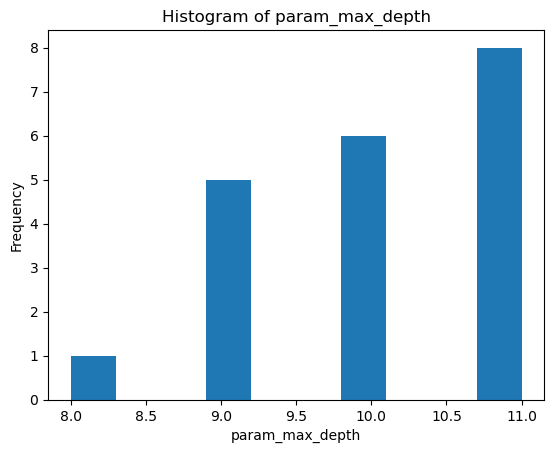

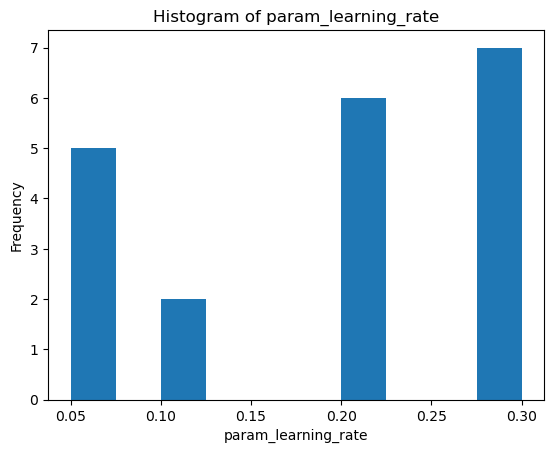

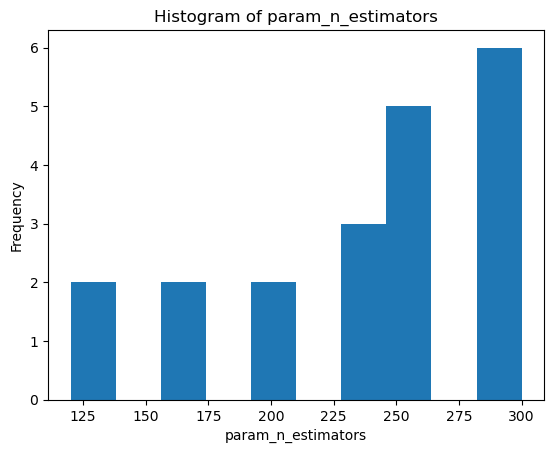

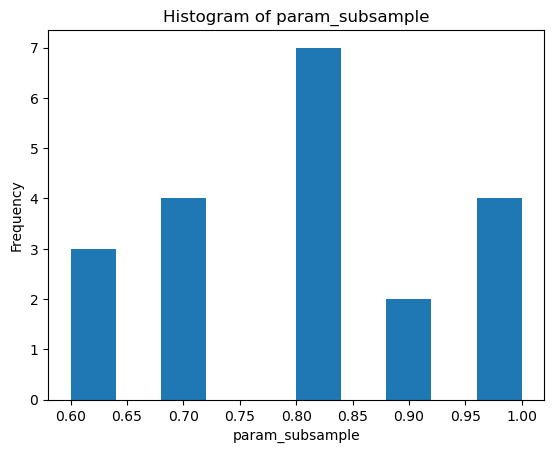

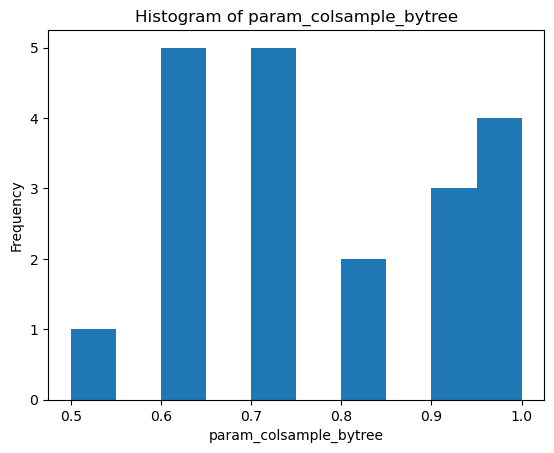

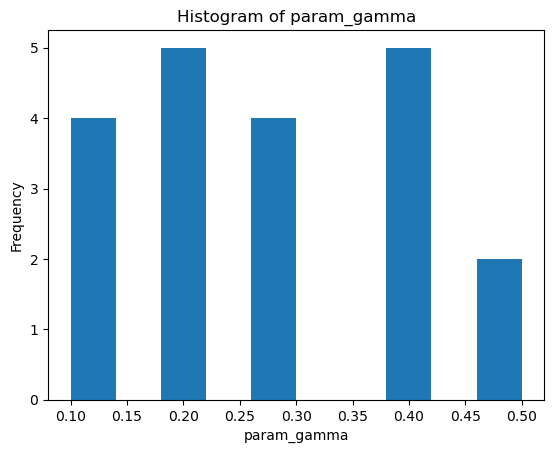

In [6]:
import matplotlib.pyplot as plt

# 선택된 row들의 변수값 추출
selected_rows = results_df[results_df['rank_test_score'].between(1, 20)]
selected_data = selected_rows[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'param_subsample',
                               'param_colsample_bytree', 'param_gamma']]

# 변수별로 히스토그램 도식화
for column in selected_data.columns:
    plt.figure()
    plt.hist(selected_data[column])
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title('Histogram of ' + column)
    plt.show()


# Hyperparameter optimization(2)

In [7]:
start = time.time()

xgb2 = XGBClassifier()

# cadidates for possible hyperparameters
param_dist = {                
      'max_depth': [7, 8, 9,10,11,12],
      'learning_rate': [0.16,0.18,0.2,0.22, 0.24,0.26,0.28,0.3],
      'n_estimators': [200, 220, 240, 260, 280, 300],
      'subsample': [0.7,0.75,0.8,0.85,0.9],
      'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
      'gamma':[0.1,0.2,0.3,0.4]
}  
                   
random_search = RandomizedSearchCV(
    estimator=xgb2,
    param_distributions=param_dist,
    n_iter=100,
    cv=2,             
    scoring='accuracy',  
    random_state=42
)

random_search.fit(x_train, y_train)

# Best hyper parameter and its accuracy score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)
print()
print("###time: ,", time.time() - start)

Best Hyperparameters: {'subsample': 0.75, 'n_estimators': 240, 'max_depth': 12, 'learning_rate': 0.16, 'gamma': 0.1, 'colsample_bytree': 0.6}
Best Score: 0.7854646103281109

###time: , 3983.7873079776764


# Optimization in a narrower scope

In [8]:
# Exploring what's in randomsearchcv
results_df = pd.DataFrame(random_search.cv_results_)
# Display all the results
pd.set_option('display.max_columns', None) 
print(results_df)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       20.578107      0.196398         0.125821        0.001068   
1       22.367493      0.182822         0.175350        0.001051   
2       20.446357      0.005488         0.216182        0.001513   
3       22.487987      0.058187         0.201293        0.000675   
4       22.288154      0.146042         0.169233        0.000277   
..            ...           ...              ...             ...   
95      14.899233      0.053599         0.152580        0.001917   
96      13.150911      0.040848         0.093421        0.000143   
97      15.038540      0.106521         0.125417        0.001628   
98      27.926842      0.502934         0.163863        0.000015   
99      27.338527      0.148910         0.186028        0.000221   

   param_subsample param_n_estimators param_max_depth param_learning_rate  \
0              0.9                240               9                0.22   
1              0.7           

## Visualization

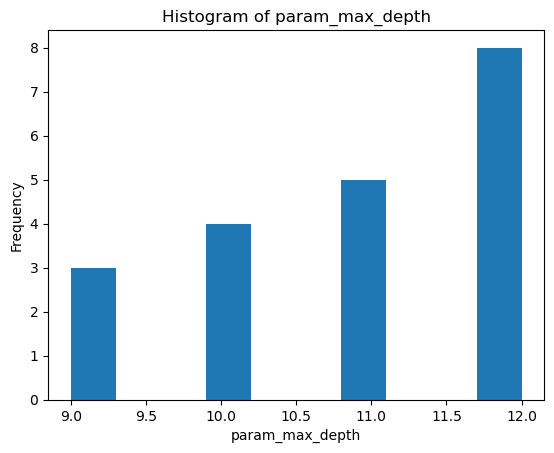

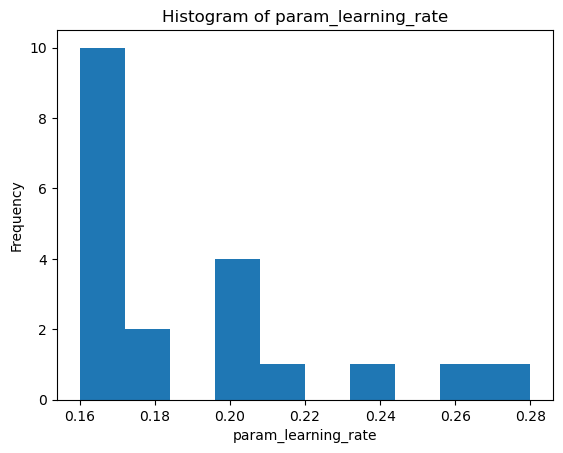

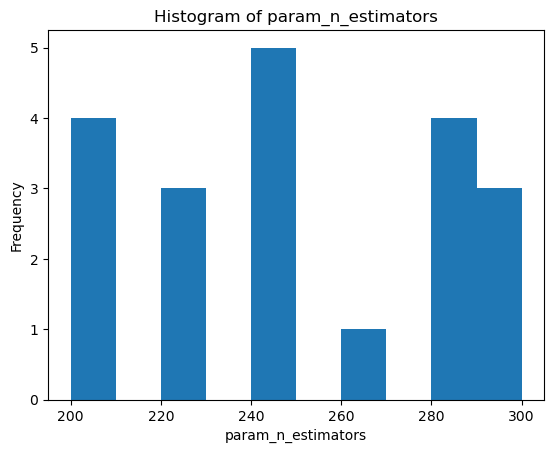

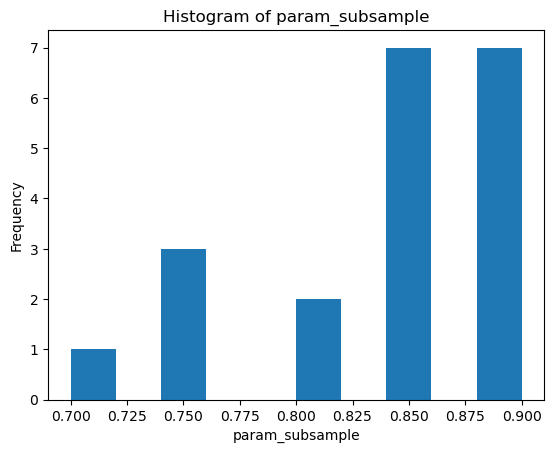

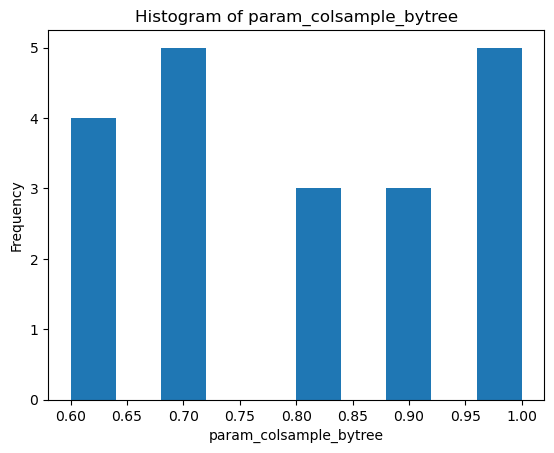

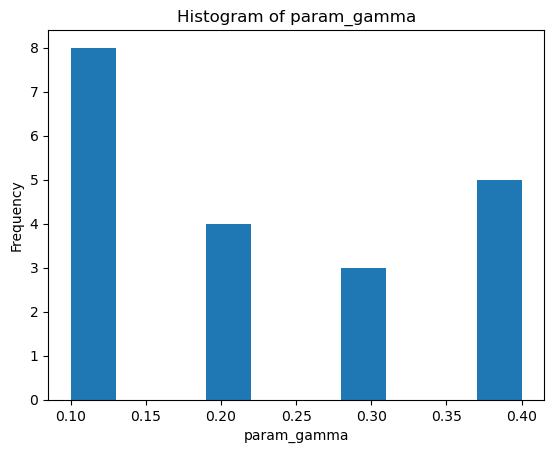

In [9]:
import matplotlib.pyplot as plt

# 선택된 row들의 변수값 추출
selected_rows = results_df[results_df['rank_test_score'].between(1, 20)]
selected_data = selected_rows[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'param_subsample',
                               'param_colsample_bytree', 'param_gamma']]

# 변수별로 히스토그램 도식화
for column in selected_data.columns:
    plt.figure()
    plt.hist(selected_data[column])
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title('Histogram of ' + column)
    plt.show()


# Hyperparameter optimization(3)

In [10]:
start = time.time()

xgb3 = XGBClassifier()

# cadidates for possible hyperparameters
param_dist = {                
      'max_depth': [7,8, 9,10,11,12,13],
      'learning_rate': [0.1,0.12,0.14,0.16,0.18,0.2],
      'n_estimators': [200, 220, 240, 260, 280],
      'subsample': [0.75,0.80,0.85,0.9,0.95],
      'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
      'gamma':[0.05,0.1,0.15,0.2,0.25]
}  
                   
random_search = RandomizedSearchCV(
    estimator=xgb3,
    param_distributions=param_dist,
    n_iter=100,
    cv=2,             
    scoring='accuracy',  
    random_state=42
)

random_search.fit(x_train, y_train)

# Best hyper parameter and its accuracy score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)
print()
print("###time: ,", time.time() - start)

Best Hyperparameters: {'subsample': 0.9, 'n_estimators': 220, 'max_depth': 13, 'learning_rate': 0.12, 'gamma': 0.15, 'colsample_bytree': 0.6}
Best Score: 0.7877245894565653

###time: , 4364.250169277191


# Test data

In [11]:
xgb_final = XGBClassifier(subsample=0.9, n_estimators=220, gamma=0.15, max_depth=13, learning_rate=0.12, colsample_bytree=0.6)
# Fit the model to the training data
xgb_final.fit(x_train, y_train)

# Predict using the trained model
y_pred = xgb_final.predict(x_test)

# Evaluate the model performance on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8203338391502276


# Conclusion
Default parameter accuracy (xgb_default) : 0.7722

Multiple optimization accuracy (xgb_final) : 0.8203

# Visualization

In [9]:
evals = dict()
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    evals[str(name)] = [train_accuracy, test_accuracy]
    print("Training Accuracy " + str(name) + " {}  Test Accuracy ".format(train_accuracy*100) + str(name) + " {}".format(test_accuracy*100))
    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Poor', 'Standard','Good'])

    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid(False)
    cm_display.plot(ax=ax)

def feature_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)
    plt.figure(figsize=(15,8))
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('Feature importances for XGBoost')
    plt.show()
    
features = process_df.drop(['Credit_Score'] , axis = 1)

Training Accuracy XGBoost 100.0  Test Accuracy XGBoost 82.03338391502277


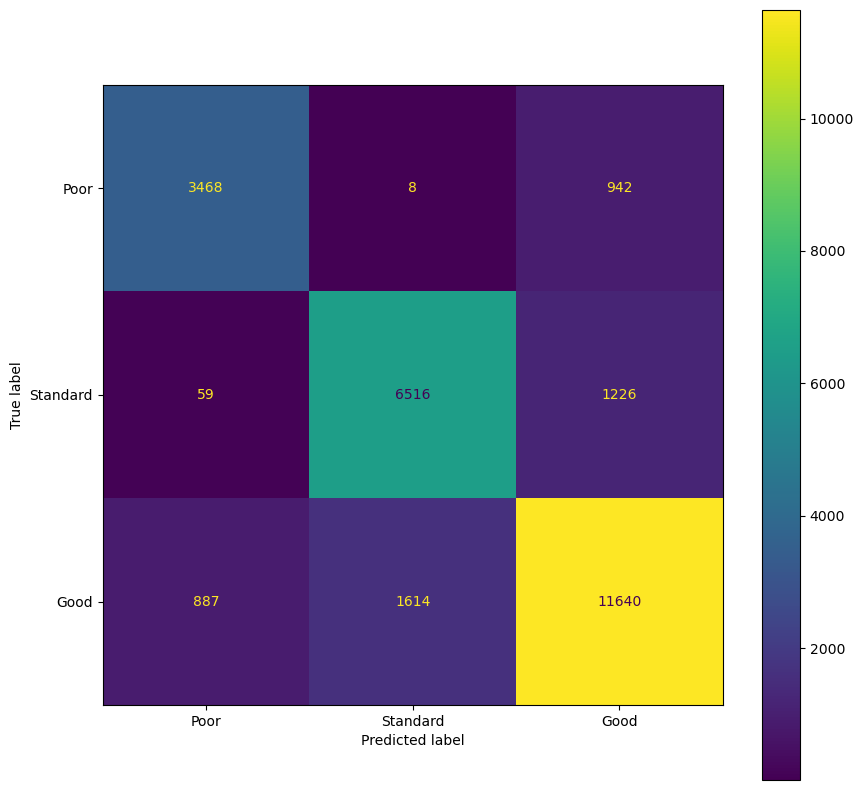

In [10]:
evaluate_classification(xgb_final, "XGBoost", x_train,x_test,y_train,y_test)

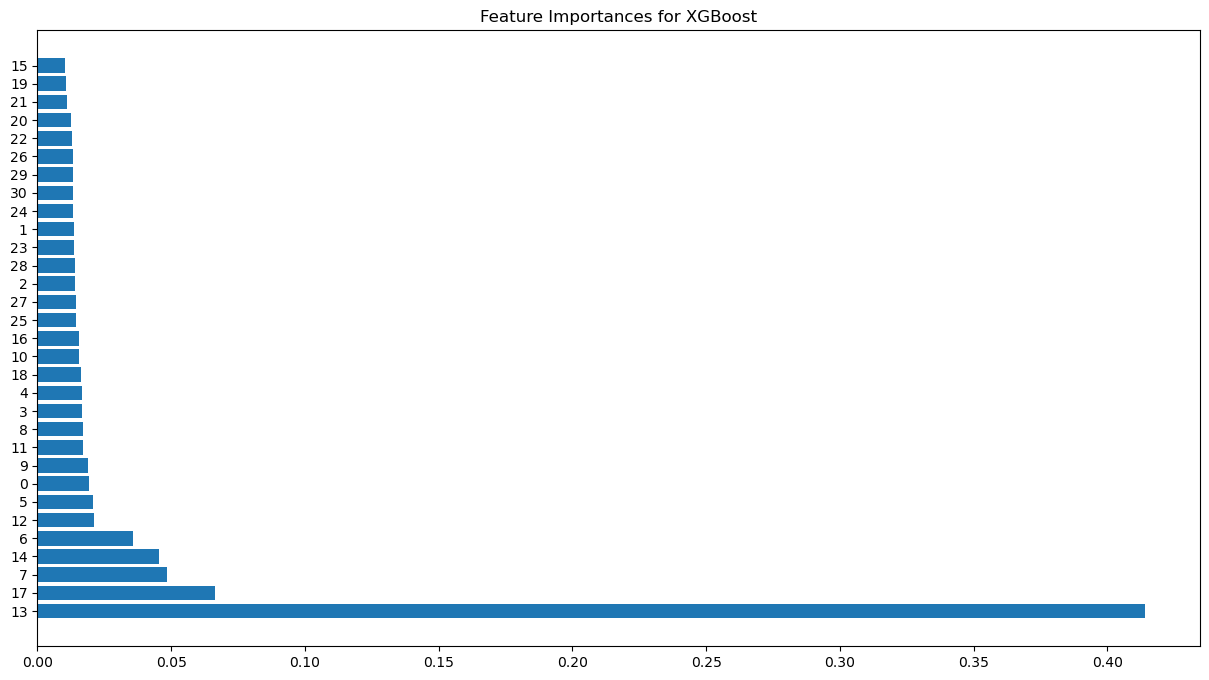

In [12]:
xgb_final = XGBClassifier(objective='multi:softmax',subsample=0.9, n_estimators=220, gamma=0.15, max_depth=13, learning_rate=0.12, colsample_bytree=0.6)
xgb_final.fit(x_train, y_train)

# Call the feature_importances() function
def feature_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)
    plt.figure(figsize=(15,8))
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('Feature Importances for XGBoost')
    plt.show()

x_train_df = pd.DataFrame(x_train)
y_train_df = pd.DataFrame(y_train)
features = x_train_df
feature_importances(abs(xgb_final.feature_importances_), features, top=-1)

# Accuracy changes when each variable is removed

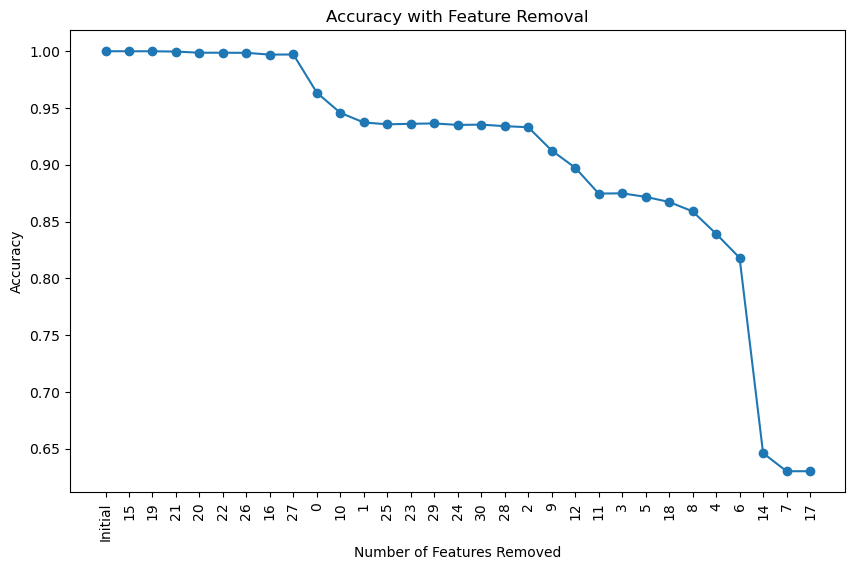

In [13]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
accuracy_scores = []
removed_features = []

xgb_final = XGBClassifier(subsample=0.9, n_estimators=220, gamma=0.15, max_depth=13, learning_rate=0.12, colsample_bytree=0.6)
# Fit the model to the training data
xgb_final.fit(x_train, y_train)

def evaluate_feature_removal(features, target):
    # Get the initial feature set and target values
    X = features.values
    y = target.values

    # Train the initial model
    model = xgb_final
    model.fit(X, y)
    initial_accuracy = accuracy_score(y, model.predict(X))
    accuracy_scores.append(initial_accuracy)

    # Iterate through feature removal
    for i in range(features.shape[1] - 1):
        # Get the feature importances
        coef = model.feature_importances_
        names = features.columns

        # Remove the least important feature
        least_important_feature = names[coef.argmin()]
        removed_features.append(least_important_feature)
        features = features.drop(least_important_feature, axis=1)

        # Update the feature set
        X = features.values
        model.fit(X, y)
        accuracy = accuracy_score(y, model.predict(X))
        accuracy_scores.append(accuracy)

    # Plot accuracy scores with removed features
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(accuracy_scores)), accuracy_scores, marker='o')
    plt.xlabel('Number of Features Removed')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with Feature Removal')
    
    # Add removed feature labels to x-axis ticks
    plt.xticks(range(len(accuracy_scores)), ['Initial'] + removed_features)
    plt.xticks(rotation=90)
    
    plt.show()

# Assuming you have 'process_df' DataFrame and 'Credit_Score' column already defined
features = x_train_df
target = y_train_df

# Evaluate feature removal
evaluate_feature_removal(features, target)

# Find the first index that has a lot of impact on accuracy

In [14]:
def find_decreasing_index(accuracy_scores):
    # Iterate over the array values
    for i in range(2, len(accuracy_scores)):
        if accuracy_scores[i] <= accuracy_scores[i-1] - 0.01:
            # Found the index where the value decreases by 0.01 or more
            print("Index:", i-2)
            break

find_decreasing_index(accuracy_scores)

Index: 7


# Other unimportant features removed and show important features

In [15]:
X = process_df.values
X[:,30]

array([1, 1, 1, ..., 0, 0, 0], dtype=object)

In [16]:
column_indices = [np.where(features.columns == feature)[0][0] for feature in removed_features[:8]]

# Remove the columns from process_df

x_train_removed = np.delete(x_train, column_indices, axis=1)
x_test_removed= np.delete(x_test, column_indices, axis=1)
columns = features.columns.tolist()
columns = [column for i, column in enumerate(columns) if i not in column_indices]
print(columns) # selected index
process_df.columns[columns] # selected column name

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 23, 24, 25, 28, 29, 30]


Index(['Month', 'Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Auto Loan',
       'Credit-Builder Loan', 'Debt Consolidation Loan', 'Not Specified',
       'Payday Loan', 'Personal Loan'],
      dtype='object')

# Accuracy for removed test data

In [18]:
# Run the model with reduced features
# xgb_final = lgbClassifier(subsample= 0.86,n_estimators= 244, min_split_gain= 0.09, max_depth= 11, learning_rate= 0.26, colsample_bytree= 0.8,objective='multiclass')
xgb_final = XGBClassifier(subsample=0.9, n_estimators=220, gamma=0.15, max_depth=13, learning_rate=0.12, colsample_bytree=0.6)
xgb_final.fit(x_train_removed, y_train)
y_pred_removed = xgb_final.predict(x_test_removed)

# Evaluate the model performance on the test data
accuracy = accuracy_score(y_test, y_pred_removed)
print('xgb_accuracy(var_elimination) : ',accuracy)

xgb_accuracy(var_elimination) :  0.8335735963581183
